Last three have a very less data for training as the networks were very big.


# Importing Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Pipelining and Preprocessing

Note: Train with other type of data also

In [1]:
from tensorflow.keras.preprocessing import image

import numpy as np
import tensorflow as tf

from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import os
import time

from matplotlib import pyplot as plt
from IPython import display
from tqdm import tqdm

Using Dataset_2 as the main training data for results

In [2]:
PATH = '/content/drive/My Drive/COVID-19_Project/Classification_of_Medical_Images/Final_Dataset_Augmented_and_mirror_all_new/'

In [3]:
IMG_WIDTH = 331
IMG_HEIGHT = 331

In [4]:
data_dir_list = os.listdir(PATH)
data_dir_list

['Covid-19', 'Normal', 'Pneumonia']

In [5]:
img_data_list = []
image_path_list = []

In [6]:
for dataset in data_dir_list:
    img_list = os.listdir(PATH+dataset+'/')
    print('Loading the images of dataset - '+ '{}\n'.format(dataset))
    count = 0
    for img in tqdm(img_list):
        img_path = PATH+dataset+'/'+img
        image_path_list.append(img_path)
        img = image.load_img(img_path, target_size=(IMG_WIDTH,IMG_HEIGHT))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        img_data_list.append(x)
        count = count+1
        if count == 600:
          # otherwise make 700-700 divisions
          break

  2%|▏         | 18/1000 [00:00<00:05, 176.73it/s]

Loading the images of dataset - Covid-19



  2%|▏         | 24/1000 [00:00<00:04, 231.62it/s]

Loading the images of dataset - Normal



  2%|▏         | 21/1000 [00:00<00:04, 205.63it/s]

Loading the images of dataset - Pneumonia



 59%|█████▉    | 588/1000 [00:02<00:01, 213.00it/s]


In [7]:
img_data = np.array(img_data_list)
img_data = np.rollaxis(img_data,1,0)
img_data = img_data[0]
img_data = img_data.astype('int32')
img_data = np.abs(img_data)
print(img_data.shape)

(1800, 331, 331, 3)


In [8]:
len(image_path_list)

1800

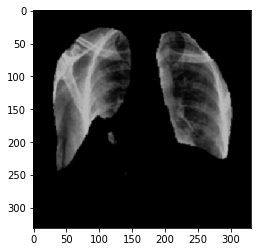

In [9]:
plt.imshow(img_data[500])

In [10]:
img_data.dtype

dtype('int32')

# Neural Network Training

Note: use other networks also

## Data Preprocessing 

In [11]:
num_classes = 3
num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples), dtype = 'int32')

In [12]:
labels[:400] = 0
labels[400:800] = 1
labels[800:] = 2

names = ['Covid-19', 'Normal', 'Pneumonia']

In [13]:
labels.shape

(1200,)

In [14]:
Y = np_utils.to_categorical(labels, num_classes)

x,y = shuffle(img_data,Y, random_state=2)

#X_model, X_test,Y_model, Y_test = train_test_split(x, y, test_size = 0.1, random_state = 2)

X_train_NN, X_test_NN, y_train_NN, y_test_NN = train_test_split(x, y, test_size = 0.2, random_state = 2)

In [15]:
X_test_NN.shape

(240, 331, 331, 3)

In [16]:
X_train_NN.shape

(960, 331, 331, 3)

In [17]:
y_train_NN.shape

(960, 3)

## Training

90

In [18]:
import tensorflow as tf
# shape 299, 299, 3

In [20]:
NASNetLarge = tf.keras.applications.NASNetLarge(
    include_top=True, weights='imagenet', input_tensor=None, input_shape=None,
    pooling=None, classes=1000
)

359751680/359748576 [==============================] - 23s 0us/step


In [21]:
NASNetLarge.summary()

Model: "NASNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 331, 331, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 165, 165, 96) 2592        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 165, 165, 96) 384         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation (Activation)         (None, 165, 165, 96) 0           stem_bn1[0][0]                   
_____________________________________________________________________________________________

In [22]:
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.models import Model
last_layer = NASNetLarge.get_layer('global_average_pooling2d').output
x = Dense(1024, activation='relu', name='fc1')(last_layer)
x = Dense(512, activation='relu', name='fc2')(x)
x = Dense(256, activation='relu', name='fc3')(x)
out = Dense(num_classes, activation = 'softmax', name = 'output')(x)
custom_model = Model(NASNetLarge.input, out)

In [23]:
for layer in custom_model.layers[:-4]:
    layer.trainable = False

In [24]:
opt = tf.keras.optimizers.Adam(
    learning_rate=0.001
)

In [25]:
custom_model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics=['accuracy'])

In [26]:
custom_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 331, 331, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 165, 165, 96) 2592        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 165, 165, 96) 384         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation (Activation)         (None, 165, 165, 96) 0           stem_bn1[0][0]                   
_______________________________________________________________________________________

In [27]:
from tensorflow.keras.applications.nasnet import preprocess_input
X_train_pp = preprocess_input(X_train_NN)
X_test_pp = preprocess_input(X_test_NN)
#X_test = preprocess_input(X_test)

In [28]:
callbacks = [
    #tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
    #tf.keras.callbacks.TensorBoard(log_dir='logs\{}'.format(NAME)),
    tf.keras.callbacks.ModelCheckpoint('NASNetLarge.h5', save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau()]

In [29]:
custom_model.fit(X_train_pp, y_train_NN, batch_size=32, epochs=100, verbose=1, validation_data = (X_test_pp, y_test_NN), callbacks = callbacks)

Epoch 1/100
38/38 [==============================] - 110s 3s/step - loss: 0.6543 - accuracy: 0.7042 - val_loss: 0.3898 - val_accuracy: 0.8667
Epoch 2/100
38/38 [==============================] - 103s 3s/step - loss: 0.3489 - accuracy: 0.8642 - val_loss: 0.2375 - val_accuracy: 0.9067
Epoch 3/100
38/38 [==============================] - 100s 3s/step - loss: 0.2309 - accuracy: 0.9108 - val_loss: 0.3052 - val_accuracy: 0.8867
Epoch 4/100
38/38 [==============================] - 103s 3s/step - loss: 0.2280 - accuracy: 0.9150 - val_loss: 0.2364 - val_accuracy: 0.9033
Epoch 5/100
38/38 [==============================] - 103s 3s/step - loss: 0.1423 - accuracy: 0.9517 - val_loss: 0.2222 - val_accuracy: 0.9333
Epoch 6/100
38/38 [==============================] - 100s 3s/step - loss: 0.1462 - accuracy: 0.9467 - val_loss: 0.3107 - val_accuracy: 0.8967
Epoch 7/100
38/38 [==============================] - 103s 3s/step - loss: 0.1921 - accuracy: 0.9283 - val_loss: 0.2165 - val_accuracy: 0.9233
Epoch 

In [30]:
classifier = tf.keras.models.load_model("NASNetLarge.h5")

In [31]:
from sklearn.metrics import confusion_matrix,classification_report
y_pred = classifier.predict(X_test_pp)
y_p = np.argmax(y_pred,axis=1)
y_true = np.argmax(y_test_NN,axis=1)
print('confusion matrix')
print(confusion_matrix(y_true,y_p))

confusion matrix
[[98  0  5]
 [ 0 98  6]
 [ 1  3 89]]


In [32]:
print('Classification report')
print(classification_report(y_true,y_p))

Classification report
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       103
           1       0.97      0.94      0.96       104
           2       0.89      0.96      0.92        93

    accuracy                           0.95       300
   macro avg       0.95      0.95      0.95       300
weighted avg       0.95      0.95      0.95       300



###Testing the model with ML techniques

In [19]:
classifier = tf.keras.models.load_model("NASNetLarge.h5")

In [20]:
from tensorflow.keras.models import Model

op_layer = classifier.get_layer('fc3').output
Model_new = Model(inputs = classifier.input , outputs = op_layer)

In [21]:
Model_new.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 331, 331, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 165, 165, 96) 2592        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 165, 165, 96) 384         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation (Activation)         (None, 165, 165, 96) 0           stem_bn1[0][0]                   
_______________________________________________________________________________________

In [22]:
x_new,y_new = shuffle(img_data,labels, random_state=2)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(x_new, y_new, test_size = 0.1, random_state = 2)

In [23]:
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
X_train_1 = preprocess_input(X_train_1)
X_test_1 = preprocess_input(X_test_1)

In [24]:
y_train_1.shape

(1080,)

In [25]:
train_new = Model_new.predict(X_train_1)
test_new = Model_new.predict(X_test_1)
print(test_new)

[[0.         0.         2.5703244  ... 2.9040763  0.         0.        ]
 [0.         0.         0.         ... 0.         0.76800686 0.        ]
 [0.         0.         0.         ... 0.         0.7213818  0.        ]
 ...
 [0.         0.         8.269138   ... 9.249054   0.         0.        ]
 [0.         0.         0.         ... 0.         1.0872923  0.        ]
 [0.         0.         0.         ... 0.         0.65657574 0.        ]]


In [26]:
test_new.shape

(120, 256)

#### svm

94 and 90

In [27]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', max_iter = 50000)

svm.fit(train_new,y_train_1)
print('fitting done !!!')
svm.score(train_new,y_train_1)

fitting done !!!


0.9824074074074074

fc3

In [28]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = svm.predict(test_new)
y_true = y_test_1
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[41  0  0]
 [ 0 41  2]
 [ 0  1 35]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        41
           1       0.98      0.95      0.96        43
           2       0.95      0.97      0.96        36

    accuracy                           0.97       120
   macro avg       0.97      0.98      0.97       120
weighted avg       0.98      0.97      0.98       120



#### xg_boost

92 and 91

In [29]:
import xgboost as xgb

xb = xgb.XGBClassifier(max_iter = 50000)

xb.fit(train_new,y_train_1)

print('fitting done !!!')

xb.score(train_new,y_train_1)

fitting done !!!


1.0

fc3

In [30]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = xb.predict(test_new)
y_true = y_test_1
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[41  0  0]
 [ 1 41  1]
 [ 0  1 35]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        41
           1       0.98      0.95      0.96        43
           2       0.97      0.97      0.97        36

    accuracy                           0.97       120
   macro avg       0.97      0.98      0.97       120
weighted avg       0.97      0.97      0.97       120



#### random forest

93 and 90

In [31]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(n_estimators=2000)
rf.fit(train_new,y_train_1)

print('fitting done !!!')

rf.score(train_new,y_train_1)

fitting done !!!


1.0

fc3

In [32]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = rf.predict(test_new)
y_true = y_test_1
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[41  0  0]
 [ 1 41  1]
 [ 0  1 35]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        41
           1       0.98      0.95      0.96        43
           2       0.97      0.97      0.97        36

    accuracy                           0.97       120
   macro avg       0.97      0.98      0.97       120
weighted avg       0.97      0.97      0.97       120



# Descriptors Extraction and Training

## Preprocessing the Data

In [11]:
! pip install opencv-python==3.4.2.16
! pip install opencv-contrib-python==3.4.2.16

     |████████████████████████████████| 25.0MB 1.6MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
     |████████████████████████████████| 30.6MB 107kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


Using: SIFT

In [12]:
import cv2

In [13]:
sift = cv2.xfeatures2d.SIFT_create()
des_list = []

In [14]:
for i in tqdm(range(len(img_data))):
  img = img_data[i].copy()
  img = np.uint8(img)
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  kpts, des = sift.detectAndCompute(img, None)
  des_list.append((i, des))




  0%|          | 0/1800 [00:00<?, ?it/s]


  0%|          | 2/1800 [00:00<01:58, 15.12it/s]


  0%|          | 4/1800 [00:00<01:56, 15.46it/s]


  0%|          | 6/1800 [00:00<01:53, 15.81it/s]


  0%|          | 8/1800 [00:00<01:55, 15.58it/s]


  1%|          | 10/1800 [00:00<01:48, 16.53it/s]


  1%|          | 12/1800 [00:00<01:43, 17.27it/s]


  1%|          | 14/1800 [00:00<01:41, 17.68it/s]


  1%|          | 16/1800 [00:00<01:42, 17.41it/s]


  1%|          | 18/1800 [00:01<01:41, 17.60it/s]


  1%|          | 20/1800 [00:01<01:40, 17.68it/s]


  1%|          | 22/1800 [00:01<01:43, 17.25it/s]


  1%|▏         | 24/1800 [00:01<01:44, 17.00it/s]


  1%|▏         | 26/1800 [00:01<01:49, 16.27it/s]


  2%|▏         | 28/1800 [00:01<01:52, 15.80it/s]


  2%|▏         | 30/1800 [00:01<01:50, 16.06it/s]


  2%|▏         | 32/1800 [00:01<01:51, 15.90it/s]


  2%|▏         | 34/1800 [00:02<01:48, 16.25it/s]


  2%|▏         | 36/1800 [00:02<01:46, 16.56it/s]


  2%|▏         | 38/18

In [15]:
image = cv2.drawKeypoints(image=img, outImage=img, keypoints=kpts, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

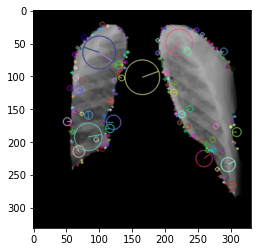

In [16]:
plt.imshow(image)
plt.show()

Using BRISK

In [11]:
import cv2

In [12]:
brisk = cv2.BRISK_create(50)
des_list = []

In [13]:
for i in tqdm(range(len(img_data))):
  img = img_data[i].copy()
  img = np.uint8(img)
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  kpts, des = brisk.detectAndCompute(img, None)
  des_list.append((i, des))

100%|██████████| 1800/1800 [00:13<00:00, 137.04it/s]


In [14]:
image = cv2.drawKeypoints(image=img, outImage=img, keypoints=kpts, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

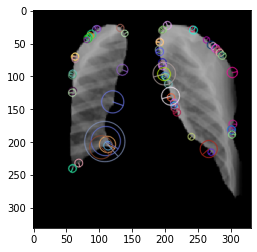

In [15]:
plt.imshow(image)
plt.show()

stacking all the descriptors vertically in a numpy array

In [16]:
descriptors = des_list[0][1]
for img_no, descriptor in tqdm(des_list[:]):
  try:
    descriptors = np.vstack((descriptors, descriptor))
  except:
    continue

100%|██████████| 1800/1800 [00:03<00:00, 494.24it/s]


In [17]:
descriptors_float = descriptors.astype(float)

Clustring using k means

Note: use others methods also

In [18]:
from scipy.cluster.vq import kmeans, vq
# we can change the value of k (no of clusters) to see the different accuracies
k = 128
voc, variance = kmeans(descriptors_float, k, 1)

calculating the histogram of the features and representing them as vectors.

vq(vector quantization) Assigns codes from a code book to observations.

In [19]:
im_features = np.zeros((len(img_data), k), "float32")
for i in tqdm(range(len(img_data))):
  try:
    words, distance = vq(des_list[i][1],voc)
    for w in words:
      im_features[i][w] += 1
  except:
    continue 

100%|██████████| 1800/1800 [00:03<00:00, 598.85it/s]


performing Tf-Idf vectorization

In [20]:
nbr_occurances = np.sum((im_features > 0) * 1, axis = 0)
idf = np.array(np.log((1.0*len(img_data) + 1) / (1.0*nbr_occurances + 1)), "float32")

Scaling the words

Standardize features by removing the mean and scaling to unit variance

In a way normalizarion

In [21]:
from sklearn.preprocessing import StandardScaler
stdSlr = StandardScaler().fit(im_features)
im_features = stdSlr.transform(im_features)

In [22]:
im_features.shape

(1800, 128)

In [23]:
im_features.dtype

dtype('float32')

In [24]:
im_features

array([[ 0.11761712,  0.17677987,  0.15379812, ..., -0.27692604,
        -0.24474585, -1.0344484 ],
       [ 1.0482141 ,  2.554984  , -0.9647336 , ...,  1.0567647 ,
         0.48222202, -0.37086785],
       [-0.34768134,  0.65242076,  0.71306396, ...,  0.05649662,
         1.2091898 ,  0.95629334],
       ...,
       [-0.34768134, -0.29886103, -0.9647336 , ..., -0.27692604,
         1.2091898 , -1.0344484 ],
       [-0.34768134, -0.29886103, -0.9647336 , ..., -0.27692604,
        -0.9717137 , -1.0344484 ],
       [-0.34768134, -0.29886103, -0.9647336 , ..., -0.27692604,
        -0.24474585, -0.37086785]], dtype=float32)

## Train and Test spliting 

In [25]:
num_classes = 3
num_of_samples = im_features.shape[0]
labels = np.ones((num_of_samples), dtype = 'int32')

labels[:600] = 0
labels[600:1200] = 1
labels[1200:] = 2

names = ['Covid-19', 'Normal', 'Pneumonia']

In [26]:
x,y = shuffle(im_features,labels, random_state=2)

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(x, y, test_size = 0.15, random_state = 2)

In [27]:
X_train_d.shape

(1530, 128)

In [28]:
y_train_d.shape

(1530,)

## Training with SIFT

### Training on SVM

In [30]:
from sklearn.svm import SVC
svm = SVC(max_iter = 50000)
svm.fit(X_train_d, y_train_d)
print('fitting done !!!')

fitting done !!!


In [31]:
svm.score(X_train_d,y_train_d)

0.9215686274509803

In [32]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = svm.predict(X_test_d)
y_true = y_test_d
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[81  1  8]
 [ 0 78  8]
 [ 4 10 80]]
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        90
           1       0.88      0.91      0.89        86
           2       0.83      0.85      0.84        94

    accuracy                           0.89       270
   macro avg       0.89      0.89      0.89       270
weighted avg       0.89      0.89      0.89       270



### Training on XG_boost

In [33]:
import xgboost as xgb

xb = xgb.XGBClassifier(max_iter = 50000)

xb.fit(X_train_d,y_train_d)

print('fitting done !!!')

fitting done !!!


In [34]:
xb.score(X_train_d,y_train_d)

0.9647058823529412

In [35]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = xb.predict(X_test_d)
y_true = y_test_d
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[82  2  6]
 [ 0 76 10]
 [ 4 15 75]]
              precision    recall  f1-score   support

           0       0.95      0.91      0.93        90
           1       0.82      0.88      0.85        86
           2       0.82      0.80      0.81        94

    accuracy                           0.86       270
   macro avg       0.86      0.86      0.86       270
weighted avg       0.87      0.86      0.86       270



### Training on Random Forest

In [36]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(n_estimators=1000)
rf.fit(X_train_d,y_train_d)

print('fitting done !!!')

fitting done !!!


In [37]:
rf.score(X_train_d,y_train_d)

1.0

In [38]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = rf.predict(X_test_d)
y_true = y_test_d
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[78  5  7]
 [ 0 77  9]
 [ 4 18 72]]
              precision    recall  f1-score   support

           0       0.95      0.87      0.91        90
           1       0.77      0.90      0.83        86
           2       0.82      0.77      0.79        94

    accuracy                           0.84       270
   macro avg       0.85      0.84      0.84       270
weighted avg       0.85      0.84      0.84       270



## Training with BRISK

### Training on SVM

In [29]:
from sklearn.svm import SVC
svm = SVC(max_iter = 50000)
svm.fit(X_train_d, y_train_d)
print('fitting done !!!')

fitting done !!!


In [30]:
svm.score(X_train_d,y_train_d)

0.8980392156862745

In [31]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = svm.predict(X_test_d)
y_true = y_test_d
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[75  6  9]
 [ 0 70 16]
 [10 16 68]]
              precision    recall  f1-score   support

           0       0.88      0.83      0.86        90
           1       0.76      0.81      0.79        86
           2       0.73      0.72      0.73        94

    accuracy                           0.79       270
   macro avg       0.79      0.79      0.79       270
weighted avg       0.79      0.79      0.79       270



### Training on XG_boost

In [32]:
import xgboost as xgb

xb = xgb.XGBClassifier(max_iter = 50000)

xb.fit(X_train_d,y_train_d)

print('fitting done !!!')

fitting done !!!


In [33]:
xb.score(X_train_d,y_train_d)

0.9098039215686274

In [34]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = xb.predict(X_test_d)
y_true = y_test_d
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[77  2 11]
 [ 6 66 14]
 [ 9 25 60]]
              precision    recall  f1-score   support

           0       0.84      0.86      0.85        90
           1       0.71      0.77      0.74        86
           2       0.71      0.64      0.67        94

    accuracy                           0.75       270
   macro avg       0.75      0.75      0.75       270
weighted avg       0.75      0.75      0.75       270



### Training on Random Forest

In [35]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(n_estimators=1000)
rf.fit(X_train_d,y_train_d)

print('fitting done !!!')

fitting done !!!


In [36]:
rf.score(X_train_d,y_train_d)

1.0

In [37]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = rf.predict(X_test_d)
y_true = y_test_d
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[78  1 11]
 [ 2 71 13]
 [ 6 22 66]]
              precision    recall  f1-score   support

           0       0.91      0.87      0.89        90
           1       0.76      0.83      0.79        86
           2       0.73      0.70      0.72        94

    accuracy                           0.80       270
   macro avg       0.80      0.80      0.80       270
weighted avg       0.80      0.80      0.80       270



# Combining all the Processes

In [38]:
import tensorflow as tf

In [39]:
Model_s = tf.keras.models.load_model("NASNetLarge.h5")

In [40]:
from tensorflow.keras.models import Model

op_layer = Model_s.get_layer('fc3').output
Model_C = Model(inputs = Model_s.input , outputs = op_layer)

In [41]:
Model_C.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 331, 331, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 165, 165, 96) 2592        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 165, 165, 96) 384         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation (Activation)         (None, 165, 165, 96) 0           stem_bn1[0][0]                   
_______________________________________________________________________________________

In [42]:
from tensorflow.keras.applications.nasnet import preprocess_input
img_data = preprocess_input(img_data)

In [43]:
Pred_fc3 = Model_C.predict(img_data)

In [44]:
Pred_fc3.shape

(1800, 256)

In [45]:
Pred_fc3.dtype

dtype('float32')

In [46]:
type(Pred_fc3)

numpy.ndarray

also using the extracted features using opencv

In [47]:
im_features.shape

(1800, 128)

In [48]:
im_features.dtype

dtype('float32')

In [49]:
type(im_features)

numpy.ndarray

combining the data from pred_fc3 and im_features

In [50]:
total_features = 384

In [51]:
total_dataset = 1800

In [52]:
feature_data = np.zeros((total_dataset, total_features), dtype = 'float32')

In [53]:
feature_data.shape

(1800, 384)

In [54]:
for i in tqdm(range(len(feature_data))):
  cv_feature = im_features[i]
  model_feature = Pred_fc3[i]
  feature_data[i] = np.concatenate((cv_feature,model_feature))

100%|██████████| 1800/1800 [00:00<00:00, 99558.86it/s]


In [55]:
feature_data

array([[ 0.11761712,  0.17677987,  0.15379812, ...,  5.1569495 ,
         0.        ,  0.        ],
       [ 1.0482141 ,  2.554984  , -0.9647336 , ...,  8.552862  ,
         0.        ,  0.        ],
       [-0.34768134,  0.65242076,  0.71306396, ...,  2.8334243 ,
         0.        ,  0.        ],
       ...,
       [-0.34768134, -0.29886103, -0.9647336 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.34768134, -0.29886103, -0.9647336 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.34768134, -0.29886103, -0.9647336 , ...,  1.5924655 ,
         0.        ,  0.        ]], dtype=float32)

Train Test split

change accordance to the type of training

In [56]:
num_classes = 3
num_of_samples = feature_data.shape[0]
labels = np.ones((num_of_samples), dtype = 'int32')

labels[:600] = 0
labels[600:1200] = 1
labels[1200:] = 2

names = ['Covid-19', 'Normal', 'Pneumonia']

Use Different Train Test Splitting --> 0.05, 0.1, 0.2, 0.3

In [57]:
# use the following line training the Deep learning Model
Y = np_utils.to_categorical(labels, num_classes)

x,y = shuffle(feature_data,Y, random_state=2)

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(x, y, test_size = 0.2, random_state = 2)

In [58]:
X_train_c.shape

(1440, 384)

In [59]:
y_train_c.shape

(1440, 3)

## Training DL model

In [60]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [61]:
model_combined = Sequential()
model_combined.add(Dense(1024, input_dim=384, activation='relu', name='dense_1'))
model_combined.add(Dense(800, activation='relu', name='dense_2'))
model_combined.add(Dense(512, activation='relu', name='dense_3'))
model_combined.add(Dense(300, activation='relu', name='dense_4'))
model_combined.add(Dense(256, activation='relu', name='dense_5'))
model_combined.add(Dense(128, activation='relu', name='dense_6'))
model_combined.add(Dense(3, activation='softmax', name = 'output_layer'))

In [62]:
opt = tf.keras.optimizers.Adam(
    learning_rate=0.001
)

In [63]:
model_combined.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics=['accuracy'])

make wider, make deeper, make wider and deeper, and also use other methods

In [64]:
model_combined.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              394240    
_________________________________________________________________
dense_2 (Dense)              (None, 800)               820000    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               410112    
_________________________________________________________________
dense_4 (Dense)              (None, 300)               153900    
_________________________________________________________________
dense_5 (Dense)              (None, 256)               77056     
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
output_layer (Dense)         (None, 3)                 3

In [67]:
callbacks = [
    #tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
    #tf.keras.callbacks.TensorBoard(log_dir='logs\{}'.format(NAME)),
    tf.keras.callbacks.ModelCheckpoint('NASNetLarge_combined_BRISK.h5', save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau()]

In [68]:
model_combined.fit(X_train_c, y_train_c, batch_size=32, epochs=100, verbose=1, validation_data = (X_test_c, y_test_c), callbacks = callbacks)

Epoch 1/100
45/45 [==============================] - 0s 9ms/step - loss: 7.5785e-06 - accuracy: 1.0000 - val_loss: 0.5740 - val_accuracy: 0.9528
Epoch 2/100
45/45 [==============================] - 0s 7ms/step - loss: 7.5785e-06 - accuracy: 1.0000 - val_loss: 0.5740 - val_accuracy: 0.9528
Epoch 3/100
45/45 [==============================] - 0s 7ms/step - loss: 7.5785e-06 - accuracy: 1.0000 - val_loss: 0.5740 - val_accuracy: 0.9528
Epoch 4/100
45/45 [==============================] - 0s 7ms/step - loss: 7.5785e-06 - accuracy: 1.0000 - val_loss: 0.5740 - val_accuracy: 0.9528
Epoch 5/100
45/45 [==============================] - 0s 7ms/step - loss: 7.5785e-06 - accuracy: 1.0000 - val_loss: 0.5740 - val_accuracy: 0.9528
Epoch 6/100
45/45 [==============================] - 0s 7ms/step - loss: 7.5785e-06 - accuracy: 1.0000 - val_loss: 0.5740 - val_accuracy: 0.9528
Epoch 7/100
45/45 [==============================] - 0s 7ms/step - loss: 7.5785e-06 - accuracy: 1.0000 - val_loss: 0.5740 - val_ac

In [70]:
Model_n = tf.keras.models.load_model("NASNetLarge_combined_BRISK.h5")

In [71]:
from sklearn.metrics import confusion_matrix,classification_report
y_pred = Model_n.predict(X_test_c)
y_p = np.argmax(y_pred,axis=1)
y_true = np.argmax(y_test_c,axis=1)
print('confusion matrix')
print(confusion_matrix(y_true,y_p))

confusion matrix
[[118   0   4]
 [  0 109   6]
 [  2   5 116]]


In [72]:
print('Classification report')
print(classification_report(y_true,y_p))

Classification report
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       122
           1       0.96      0.95      0.95       115
           2       0.92      0.94      0.93       123

    accuracy                           0.95       360
   macro avg       0.95      0.95      0.95       360
weighted avg       0.95      0.95      0.95       360



SIFT ACCURACY was 96%

## Using ML methods

In [74]:
Model_n = tf.keras.models.load_model("NASNetLarge_combined_BRISK.h5")

In [75]:
from tensorflow.keras.models import Model

op_layer = Model_n.get_layer('dense_6').output
Model_csn = Model(inputs = Model_n.input , outputs = op_layer)

In [76]:
Model_csn.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1_input (InputLayer)   [(None, 384)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              394240    
_________________________________________________________________
dense_2 (Dense)              (None, 800)               820000    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               410112    
_________________________________________________________________
dense_4 (Dense)              (None, 300)               153900    
_________________________________________________________________
dense_5 (Dense)              (None, 256)               77056     
_________________________________________________________________
dense_6 (Dense)              (None, 128)              

In [77]:
x_new,y_new = shuffle(feature_data,labels, random_state=2)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(x_new, y_new, test_size = 0.2, random_state = 2)

In [78]:
train_new = Model_csn.predict(X_train_1)
test_new = Model_csn.predict(X_test_1)
print(test_new)

[[ 0.         11.587322    0.         ...  0.          5.4431915
   0.        ]
 [24.852867    0.         28.051908   ...  0.          0.
   0.        ]
 [ 0.         18.654488    0.         ...  0.          8.68529
   0.        ]
 ...
 [ 0.          1.8540215   0.54157573 ...  3.4896      2.9019935
   0.        ]
 [ 0.          3.2170174   0.9288209  ...  6.011508    5.0231085
   0.        ]
 [55.751076    0.         63.112675   ...  0.          0.
   0.        ]]


###Results With SIFT - Scale Invarient Feature Transform

#### SVM

In [76]:
from sklearn.svm import SVC
svm = SVC(max_iter = 50000)
svm.fit(train_new, y_train_1)
print('fitting done !!!')

fitting done !!!


In [77]:
svm.score(train_new, y_train_1)

0.9875

In [78]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = svm.predict(test_new)
y_true = y_test_1
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[119   0   3]
 [  0 107   8]
 [  2   4 117]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       122
           1       0.96      0.93      0.95       115
           2       0.91      0.95      0.93       123

    accuracy                           0.95       360
   macro avg       0.95      0.95      0.95       360
weighted avg       0.95      0.95      0.95       360



#### xg_boost

In [79]:
import xgboost as xgb

xb = xgb.XGBClassifier(max_iter = 50000)

xb.fit(train_new,y_train_1)

print('fitting done !!!')

fitting done !!!


In [80]:
xb.score(train_new,y_train_1)

1.0

In [81]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = xb.predict(test_new)
y_true = y_test_1
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[121   0   1]
 [  0 107   8]
 [  2   4 117]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       122
           1       0.96      0.93      0.95       115
           2       0.93      0.95      0.94       123

    accuracy                           0.96       360
   macro avg       0.96      0.96      0.96       360
weighted avg       0.96      0.96      0.96       360



#### Random forest

In [82]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(n_estimators=1000)
rf.fit(train_new,y_train_1)

print('fitting done !!!')

fitting done !!!


In [83]:
rf.score(train_new,y_train_1)

1.0

In [84]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = rf.predict(test_new)
y_true = y_test_1
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[121   0   1]
 [  0 107   8]
 [  2   4 117]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       122
           1       0.96      0.93      0.95       115
           2       0.93      0.95      0.94       123

    accuracy                           0.96       360
   macro avg       0.96      0.96      0.96       360
weighted avg       0.96      0.96      0.96       360



###Results With BRISK - Binary Robust Invarient Scalable Keypoints

#### SVM

In [79]:
from sklearn.svm import SVC
svm = SVC(max_iter = 50000)
svm.fit(train_new, y_train_1)
print('fitting done !!!')

fitting done !!!


In [80]:
svm.score(train_new, y_train_1)

1.0

In [81]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = svm.predict(test_new)
y_true = y_test_1
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[118   0   4]
 [  0 108   7]
 [  2   3 118]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       122
           1       0.97      0.94      0.96       115
           2       0.91      0.96      0.94       123

    accuracy                           0.96       360
   macro avg       0.96      0.96      0.96       360
weighted avg       0.96      0.96      0.96       360



#### xg_boost

In [82]:
import xgboost as xgb

xb = xgb.XGBClassifier(max_iter = 50000)

xb.fit(train_new,y_train_1)

print('fitting done !!!')

fitting done !!!


In [83]:
xb.score(train_new,y_train_1)

1.0

In [84]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = xb.predict(test_new)
y_true = y_test_1
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[118   0   4]
 [  0 110   5]
 [  2   5 116]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       122
           1       0.96      0.96      0.96       115
           2       0.93      0.94      0.94       123

    accuracy                           0.96       360
   macro avg       0.96      0.96      0.96       360
weighted avg       0.96      0.96      0.96       360



#### Random forest

In [85]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(n_estimators=1000)
rf.fit(train_new,y_train_1)

print('fitting done !!!')

fitting done !!!


In [86]:
rf.score(train_new,y_train_1)

1.0

In [87]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = rf.predict(test_new)
y_true = y_test_1
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[118   0   4]
 [  0 109   6]
 [  2   5 116]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       122
           1       0.96      0.95      0.95       115
           2       0.92      0.94      0.93       123

    accuracy                           0.95       360
   macro avg       0.95      0.95      0.95       360
weighted avg       0.95      0.95      0.95       360



# Testing the models

## Dataset Preprocessing

In [88]:
from tensorflow.keras.preprocessing import image

import numpy as np

from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import os
import time

from matplotlib import pyplot as plt
from IPython import display
from tqdm import tqdm
import tensorflow as tf


In [89]:
PATH = '/content/drive/My Drive/COVID-19_Project/Classification_of_Medical_Images/Testing_Dataset/'

In [90]:
IMG_WIDTH = 331
IMG_HEIGHT = 331

In [91]:
data_dir_list = os.listdir(PATH)
data_dir_list

['Covid-19', 'Normal', 'Pneumonia']

In [92]:
img_data_list = []
image_path_list = []

In [93]:
for dataset in data_dir_list:
    img_list = os.listdir(PATH+dataset+'/')
    print('Loading the images of dataset - '+ '{}\n'.format(dataset))
    count = 0
    for img in tqdm(img_list):
        img_path = PATH+dataset+'/'+img
        image_path_list.append(img_path)
        img = image.load_img(img_path, target_size=(IMG_WIDTH,IMG_HEIGHT))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        img_data_list.append(x)
        count = count+1
        if count == 800:
          # otherwise make 700-700 divisions
          break

 29%|██▊       | 26/91 [00:00<00:00, 253.69it/s]

Loading the images of dataset - Covid-19



 31%|███       | 28/91 [00:00<00:00, 274.39it/s]

Loading the images of dataset - Normal



 29%|██▉       | 28/97 [00:00<00:00, 273.43it/s]

Loading the images of dataset - Pneumonia



100%|██████████| 97/97 [00:00<00:00, 273.79it/s]


In [94]:
img_data = np.array(img_data_list)
img_data = np.rollaxis(img_data,1,0)
img_data = img_data[0]
img_data = img_data.astype('int32')
img_data = np.abs(img_data)
print(img_data.shape)

(279, 331, 331, 3)


In [95]:
len(image_path_list)

279

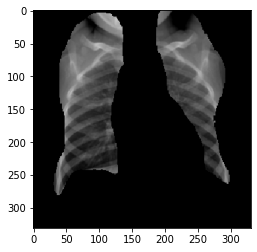

In [96]:
plt.imshow(img_data[100])

In [97]:
img_data.dtype

dtype('int32')

In [98]:
num_classes = 3
num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples), dtype = 'int32')

In [99]:
labels[:91] = 0
labels[91:182] = 1
labels[182:] = 2

names = ['Covid-19', 'Normal', 'Pneumonia']

In [100]:
labels.shape

(279,)

In [101]:
Y = np_utils.to_categorical(labels, num_classes)

X_test,Y_test = shuffle(img_data,Y, random_state=2)

## Simple Model

In [73]:
Model_n = tf.keras.models.load_model("NASNetLarge.h5")

In [74]:
from tensorflow.keras.applications.nasnet import preprocess_input
X_test = preprocess_input(X_test)

In [75]:
from sklearn.metrics import confusion_matrix,classification_report
y_pred = Model_n.predict(X_test)
y_p = np.argmax(y_pred,axis=1)
y_true = np.argmax(Y_test,axis=1)
print('confusion matrix')
print(confusion_matrix(y_true,y_p))

confusion matrix
[[85  0  6]
 [ 1 81  9]
 [ 4  7 86]]


In [76]:
print('Classification report')
print(classification_report(y_true,y_p))

Classification report
              precision    recall  f1-score   support

           0       0.94      0.93      0.94        91
           1       0.92      0.89      0.91        91
           2       0.85      0.89      0.87        97

    accuracy                           0.90       279
   macro avg       0.91      0.90      0.90       279
weighted avg       0.90      0.90      0.90       279



ML Techniques

In [77]:
classifier = tf.keras.models.load_model("NASNetLarge.h5")

In [78]:
from tensorflow.keras.models import Model

op_layer = classifier.get_layer('fc3').output
Model_new = Model(inputs = classifier.input , outputs = op_layer)

In [79]:
x_test_new,y_test_new = shuffle(img_data,labels, random_state=2)

In [80]:
from tensorflow.keras.applications.nasnet import preprocess_input
x_test_new = preprocess_input(x_test_new)

In [81]:
test_new_x = Model_new.predict(x_test_new)

svm

In [82]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = svm.predict(test_new_x)
y_true = y_test_new
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[85  0  6]
 [ 3 80  8]
 [ 4  7 86]]
              precision    recall  f1-score   support

           0       0.92      0.93      0.93        91
           1       0.92      0.88      0.90        91
           2       0.86      0.89      0.87        97

    accuracy                           0.90       279
   macro avg       0.90      0.90      0.90       279
weighted avg       0.90      0.90      0.90       279



xg_boost

In [83]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = xb.predict(test_new_x)
y_true = y_test_new
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[89  0  2]
 [ 5 78  8]
 [ 7  8 82]]
              precision    recall  f1-score   support

           0       0.88      0.98      0.93        91
           1       0.91      0.86      0.88        91
           2       0.89      0.85      0.87        97

    accuracy                           0.89       279
   macro avg       0.89      0.89      0.89       279
weighted avg       0.89      0.89      0.89       279



random_forest

In [84]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = rf.predict(test_new_x)
y_true = y_test_new
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[89  1  1]
 [ 5 78  8]
 [ 6  8 83]]
              precision    recall  f1-score   support

           0       0.89      0.98      0.93        91
           1       0.90      0.86      0.88        91
           2       0.90      0.86      0.88        97

    accuracy                           0.90       279
   macro avg       0.90      0.90      0.90       279
weighted avg       0.90      0.90      0.90       279



## Feature Extraction

### SIFT

In [99]:
! pip install opencv-python==3.4.2.16
! pip install opencv-contrib-python==3.4.2.16

In [100]:
import cv2

In [101]:
sift = cv2.xfeatures2d.SIFT_create()
des_list = []

In [102]:
for i in tqdm(range(len(img_data))):
  img = img_data[i].copy()
  img = np.uint8(img)
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  kpts, des = sift.detectAndCompute(img, None)
  des_list.append((i, des))




  0%|          | 0/279 [00:00<?, ?it/s]


  1%|          | 3/279 [00:00<00:13, 20.82it/s]


  2%|▏         | 5/279 [00:00<00:13, 19.71it/s]


  3%|▎         | 7/279 [00:00<00:14, 19.36it/s]


  4%|▎         | 10/279 [00:00<00:13, 19.86it/s]


  4%|▍         | 12/279 [00:00<00:14, 18.82it/s]


  5%|▌         | 14/279 [00:00<00:14, 18.58it/s]


  6%|▌         | 17/279 [00:00<00:13, 18.80it/s]


  7%|▋         | 19/279 [00:01<00:14, 18.50it/s]


  8%|▊         | 21/279 [00:01<00:15, 16.56it/s]


  8%|▊         | 23/279 [00:01<00:14, 17.12it/s]


  9%|▉         | 25/279 [00:01<00:14, 17.39it/s]


 10%|▉         | 27/279 [00:01<00:15, 16.24it/s]


 10%|█         | 29/279 [00:01<00:15, 15.86it/s]


 11%|█         | 31/279 [00:01<00:15, 16.06it/s]


 12%|█▏        | 33/279 [00:01<00:15, 16.12it/s]


 13%|█▎        | 35/279 [00:02<00:15, 15.85it/s]


 13%|█▎        | 37/279 [00:02<00:15, 15.13it/s]


 14%|█▍        | 39/279 [00:02<00:15, 15.81it/s]


 15%|█▍        | 41/279 [00:02<00:15, 15

In [103]:
image = cv2.drawKeypoints(image=img, outImage=img, keypoints=kpts, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

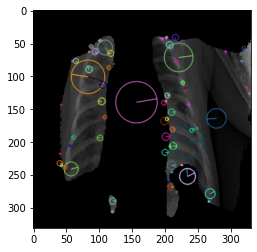

In [104]:
plt.imshow(image)
plt.show()

In [105]:
descriptors = des_list[0][1]
for img_no, descriptor in tqdm(des_list[:]):
  try:
    descriptors = np.vstack((descriptors, descriptor))
  except:
    continue




  0%|          | 0/279 [00:00<?, ?it/s]


 28%|██▊       | 78/279 [00:00<00:00, 767.48it/s]


 37%|███▋      | 104/279 [00:00<00:00, 476.07it/s]


 46%|████▌     | 128/279 [00:00<00:00, 343.65it/s]


 54%|█████▍    | 151/279 [00:00<00:00, 266.97it/s]


 62%|██████▏   | 173/279 [00:00<00:00, 203.52it/s]


 69%|██████▉   | 192/279 [00:00<00:00, 172.45it/s]


 75%|███████▍  | 209/279 [00:00<00:00, 152.35it/s]


 81%|████████  | 225/279 [00:01<00:00, 138.81it/s]


 86%|████████▌ | 240/279 [00:01<00:00, 129.38it/s]


 91%|█████████ | 254/279 [00:01<00:00, 119.82it/s]


 96%|█████████▌| 267/279 [00:01<00:00, 113.31it/s]


100%|██████████| 279/279 [00:01<00:00, 177.49it/s]


In [106]:
descriptors_float = descriptors.astype(float)

In [107]:
from scipy.cluster.vq import kmeans, vq
# we can change the value of k (no of clusters) to see the different accuracies
k = 128
voc, variance = kmeans(descriptors_float, k, 1)

In [108]:
im_features = np.zeros((len(img_data), k), "float32")
for i in tqdm(range(len(img_data))):
  try:
    words, distance = vq(des_list[i][1],voc)
    for w in words:
      im_features[i][w] += 1
  except:
    continue 




  0%|          | 0/279 [00:00<?, ?it/s]


 11%|█         | 30/279 [00:00<00:00, 296.32it/s]


 20%|█▉        | 55/279 [00:00<00:00, 278.97it/s]


 29%|██▉       | 81/279 [00:00<00:00, 270.58it/s]


 43%|████▎     | 120/279 [00:00<00:00, 297.00it/s]


 62%|██████▏   | 173/279 [00:00<00:00, 340.72it/s]


100%|██████████| 279/279 [00:00<00:00, 414.25it/s]


In [109]:
nbr_occurances = np.sum((im_features > 0) * 1, axis = 0)
idf = np.array(np.log((1.0*len(img_data) + 1) / (1.0*nbr_occurances + 1)), "float32")

In [110]:
from sklearn.preprocessing import StandardScaler
stdSlr = StandardScaler().fit(im_features)
im_features = stdSlr.transform(im_features)

In [111]:
im_features.shape

(279, 128)

In [112]:
im_features.dtype

dtype('float32')

In [113]:
Model_s = tf.keras.models.load_model("NASNetLarge.h5")

In [114]:
from tensorflow.keras.models import Model

op_layer = Model_s.get_layer('fc3').output
Model_C = Model(inputs = Model_s.input , outputs = op_layer)

In [115]:
from tensorflow.keras.applications.nasnet import preprocess_input
img_data = preprocess_input(img_data)

In [116]:
Pred_fc3 = Model_C.predict(img_data)

In [117]:
total_features = 384
total_dataset = 279

feature_data = np.zeros((total_dataset, total_features), dtype = 'float32')

for i in tqdm(range(len(feature_data))):
  cv_feature = im_features[i]
  model_feature = Pred_fc3[i]
  feature_data[i] = np.concatenate((cv_feature,model_feature))




100%|██████████| 279/279 [00:00<00:00, 124464.03it/s]


In [118]:
feature_data.shape

(279, 384)

In [119]:
num_classes = 3
num_of_samples = feature_data.shape[0]
labels = np.ones((num_of_samples), dtype = 'int32')

labels[:91] = 0
labels[91:182] = 1
labels[182:] = 2

names = ['Covid-19', 'Normal', 'Pneumonia']

In [120]:
Y = np_utils.to_categorical(labels, num_classes)

X_test_SIFT,Y_test_SIFT = shuffle(feature_data,Y, random_state=2)

In [121]:
Model_n = tf.keras.models.load_model("NASNetLarge_combined_SIFT.h5")

In [122]:
from sklearn.metrics import confusion_matrix,classification_report
y_pred = Model_n.predict(X_test_SIFT)
y_p = np.argmax(y_pred,axis=1)
y_true = np.argmax(Y_test_SIFT,axis=1)
print('confusion matrix')
print(confusion_matrix(y_true,y_p))

confusion matrix
[[85  3  3]
 [ 2 79 10]
 [ 5  5 87]]


In [123]:
print('Classification report')
print(classification_report(y_true,y_p))

Classification report
              precision    recall  f1-score   support

           0       0.92      0.93      0.93        91
           1       0.91      0.87      0.89        91
           2       0.87      0.90      0.88        97

    accuracy                           0.90       279
   macro avg       0.90      0.90      0.90       279
weighted avg       0.90      0.90      0.90       279



#### ML Techniques

In [124]:
from tensorflow.keras.models import Model

op_layer = Model_n.get_layer('dense_6').output
Model_csn = Model(inputs = Model_n.input , outputs = op_layer)

In [125]:
x_new_test,y_new_test = shuffle(feature_data,labels, random_state=2)

In [126]:
new_test_x = Model_csn.predict(x_new_test)

In [127]:
from sklearn.metrics import confusion_matrix, classification_report

svm

In [128]:
y_pred = svm.predict(new_test_x)
y_true = y_new_test
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[84  3  4]
 [ 1 79 11]
 [ 4  5 88]]
              precision    recall  f1-score   support

           0       0.94      0.92      0.93        91
           1       0.91      0.87      0.89        91
           2       0.85      0.91      0.88        97

    accuracy                           0.90       279
   macro avg       0.90      0.90      0.90       279
weighted avg       0.90      0.90      0.90       279



xg_boost

In [129]:
y_pred = xb.predict(new_test_x)
y_true = y_new_test
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[85  0  6]
 [ 1 78 12]
 [ 4  6 87]]
              precision    recall  f1-score   support

           0       0.94      0.93      0.94        91
           1       0.93      0.86      0.89        91
           2       0.83      0.90      0.86        97

    accuracy                           0.90       279
   macro avg       0.90      0.90      0.90       279
weighted avg       0.90      0.90      0.90       279



random forest

In [130]:
y_pred = rf.predict(new_test_x)
y_true = y_new_test
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[85  0  6]
 [ 1 79 11]
 [ 4  6 87]]
              precision    recall  f1-score   support

           0       0.94      0.93      0.94        91
           1       0.93      0.87      0.90        91
           2       0.84      0.90      0.87        97

    accuracy                           0.90       279
   macro avg       0.90      0.90      0.90       279
weighted avg       0.90      0.90      0.90       279



### BRISK

In [102]:
import cv2

In [103]:
brisk = cv2.BRISK_create(50)
des_list = []

In [104]:
for i in tqdm(range(len(img_data))):
  img = img_data[i].copy()
  img = np.uint8(img)
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  kpts, des = brisk.detectAndCompute(img, None)
  des_list.append((i, des))

100%|██████████| 279/279 [00:02<00:00, 134.44it/s]


In [105]:
image = cv2.drawKeypoints(image=img, outImage=img, keypoints=kpts, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

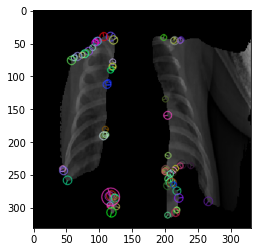

In [106]:
plt.imshow(image)
plt.show()

In [107]:
descriptors = des_list[0][1]
for img_no, descriptor in tqdm(des_list[:]):
  try:
    descriptors = np.vstack((descriptors, descriptor))
  except:
    continue

100%|██████████| 279/279 [00:00<00:00, 2619.96it/s]


In [108]:
descriptors_float = descriptors.astype(float)

In [109]:
from scipy.cluster.vq import kmeans, vq
# we can change the value of k (no of clusters) to see the different accuracies
k = 128
voc, variance = kmeans(descriptors_float, k, 1)

In [110]:
im_features = np.zeros((len(img_data), k), "float32")
for i in tqdm(range(len(img_data))):
  try:
    words, distance = vq(des_list[i][1],voc)
    for w in words:
      im_features[i][w] += 1
  except:
    continue 

100%|██████████| 279/279 [00:00<00:00, 475.93it/s]


In [111]:
nbr_occurances = np.sum((im_features > 0) * 1, axis = 0)
idf = np.array(np.log((1.0*len(img_data) + 1) / (1.0*nbr_occurances + 1)), "float32")

In [112]:
from sklearn.preprocessing import StandardScaler
stdSlr = StandardScaler().fit(im_features)
im_features = stdSlr.transform(im_features)

In [113]:
im_features.shape

(279, 128)

In [114]:
im_features.dtype

dtype('float32')

In [115]:
Model_s = tf.keras.models.load_model("NASNetLarge.h5")

In [116]:
from tensorflow.keras.models import Model

op_layer = Model_s.get_layer('fc3').output
Model_C = Model(inputs = Model_s.input , outputs = op_layer)

In [117]:
from tensorflow.keras.applications.nasnet import preprocess_input
img_data = preprocess_input(img_data)

In [118]:
Pred_fc3 = Model_C.predict(img_data)

In [119]:
total_features = 384
total_dataset = 279

feature_data = np.zeros((total_dataset, total_features), dtype = 'float32')

for i in tqdm(range(len(feature_data))):
  cv_feature = im_features[i]
  model_feature = Pred_fc3[i]
  feature_data[i] = np.concatenate((cv_feature,model_feature))

100%|██████████| 279/279 [00:00<00:00, 91537.14it/s]


In [120]:
feature_data.shape

(279, 384)

In [121]:
num_classes = 3
num_of_samples = feature_data.shape[0]
labels = np.ones((num_of_samples), dtype = 'int32')

labels[:91] = 0
labels[91:182] = 1
labels[182:] = 2

names = ['Covid-19', 'Normal', 'Pneumonia']

In [122]:
Y = np_utils.to_categorical(labels, num_classes)

X_test_SIFT,Y_test_SIFT = shuffle(feature_data,Y, random_state=2)

In [123]:
Model_n = tf.keras.models.load_model("NASNetLarge_combined_BRISK.h5")

In [124]:
from sklearn.metrics import confusion_matrix,classification_report
y_pred = Model_n.predict(X_test_SIFT)
y_p = np.argmax(y_pred,axis=1)
y_true = np.argmax(Y_test_SIFT,axis=1)
print('confusion matrix')
print(confusion_matrix(y_true,y_p))

confusion matrix
[[87  0  4]
 [ 2 79 10]
 [ 2  8 87]]


In [125]:
print('Classification report')
print(classification_report(y_true,y_p))

Classification report
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        91
           1       0.91      0.87      0.89        91
           2       0.86      0.90      0.88        97

    accuracy                           0.91       279
   macro avg       0.91      0.91      0.91       279
weighted avg       0.91      0.91      0.91       279



#### ML Techniques

In [126]:
from tensorflow.keras.models import Model

op_layer = Model_n.get_layer('dense_6').output
Model_csn = Model(inputs = Model_n.input , outputs = op_layer)

In [127]:
x_new_test,y_new_test = shuffle(feature_data,labels, random_state=2)

In [128]:
new_test_x = Model_csn.predict(x_new_test)

In [129]:
from sklearn.metrics import confusion_matrix, classification_report

svm

In [130]:
y_pred = svm.predict(new_test_x)
y_true = y_new_test
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[85  0  6]
 [ 1 79 11]
 [ 2  6 89]]
              precision    recall  f1-score   support

           0       0.97      0.93      0.95        91
           1       0.93      0.87      0.90        91
           2       0.84      0.92      0.88        97

    accuracy                           0.91       279
   macro avg       0.91      0.91      0.91       279
weighted avg       0.91      0.91      0.91       279



xg_boost

In [131]:
y_pred = xb.predict(new_test_x)
y_true = y_new_test
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[85  0  6]
 [ 1 81  9]
 [ 2  8 87]]
              precision    recall  f1-score   support

           0       0.97      0.93      0.95        91
           1       0.91      0.89      0.90        91
           2       0.85      0.90      0.87        97

    accuracy                           0.91       279
   macro avg       0.91      0.91      0.91       279
weighted avg       0.91      0.91      0.91       279



random forest

In [132]:
y_pred = rf.predict(new_test_x)
y_true = y_new_test
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[88  0  3]
 [ 1 82  8]
 [ 2  9 86]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        91
           1       0.90      0.90      0.90        91
           2       0.89      0.89      0.89        97

    accuracy                           0.92       279
   macro avg       0.92      0.92      0.92       279
weighted avg       0.92      0.92      0.92       279

